In [1]:
import copy
from pathlib import Path

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn import metrics

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Input, Embedding, Average, Lambda, Dense, BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils import to_categorical

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

/home/andrew/Envs/calibration/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Datasplitting

We are going to use the standard Train and Test splits. For validation data we are going to use 20% of the train data.

In [2]:
newsgroups_train.target.shape

(11314,)

In [3]:
newsgroups_test.target.shape

(7532,)

They use adagrad for the optimiser 

In [4]:
train_x, train_y = newsgroups_train.data, newsgroups_train.target
test_x, test_y = newsgroups_test.data, newsgroups_test.target

In [5]:
def train_val_split(x, y, test_size=0.2, random_state=None):
    splits = train_test_split(x, y, random_state=random_state, 
                              test_size=test_size, stratify=y)
    return splits
    

In [6]:
train_x, val_x, train_y, val_y = train_val_split(train_x, train_y, 0.2)
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

In [7]:
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
keras_train_x = tokenizer.texts_to_sequences(train_x)
keras_train_x = pad_sequences(keras_train_x, maxlen=None)
MAX_SEQUENCE_LENGTH = keras_train_x.shape[1]
keras_val_x = tokenizer.texts_to_sequences(val_x)
keras_val_x = pad_sequences(keras_val_x, maxlen=MAX_SEQUENCE_LENGTH)
keras_test_x = tokenizer.texts_to_sequences(test_x)
keras_test_x = pad_sequences(keras_test_x, maxlen=MAX_SEQUENCE_LENGTH)

In [8]:
MAX_SEQUENCE_LENGTH

11136

In [9]:
keras_train_x.shape

(9051, 11136)

In [10]:
keras_test_x.shape

(7532, 11136)

In [11]:
embedding_path = Path('..', '..', 'Glove Vectors', 'glove.840B.300d.txt')
EMBEDDING_DIM = 300

embeddings_index = {}
with embedding_path.open('r') as embedding_file:
    for line in embedding_file:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            pass
print(f'Found {len(embeddings_index)} word vectors.')

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(f'Size of the embedding matrix {embedding_matrix.shape}')

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=True,
                            trainable=True)

Found 2195884 word vectors.
Size of the embedding matrix (240800, 300)


In [12]:
keras_test_x.shape

(7532, 11136)

In [13]:
def zero_mask_mean(x):
    num_non_zero = tf.reduce_max(tf.count_nonzero(x, axis=1), axis=1)
    num_non_zero = tf.reshape(num_non_zero, [tf.shape(num_non_zero)[0], 1])
    num_non_zero = tf.cast(num_non_zero, tf.float32)
    sum_x = tf.reduce_sum(x, axis=1)
    return tf.truediv(sum_x, num_non_zero)
def mean(x):
    return tf.reduce_mean(x, axis=1)

In [14]:
def ece(predictions, confidences, labels, n_bins=10, max_ece=False):
    # Get the different bins
    bins = np.linspace(0, 1, n_bins + 1)
    low_bins = bins[:-1]
    up_bins = bins[1:]
    all_bins = zip(low_bins, up_bins)
    
    num_samples = predictions.shape[0]
    ece_bin_values = []
    # For each bin work out the weighted difference between  
    # confidence and accuracy
    for low_bin, up_bin in all_bins:
        bin_conf_indcies = np.nonzero((confidences > low_bin) &
                                      (confidences <= up_bin))
        bin_confs = confidences[bin_conf_indcies]
        bin_preds = predictions[bin_conf_indcies]
        bin_labels = labels[bin_conf_indcies]
        
        num_samples_in_bin = bin_confs.shape[0]
        if num_samples_in_bin == 0:
            ece_bin_values.append(0)
            continue
        bin_weight = num_samples_in_bin / num_samples
        
        bin_acc = (bin_labels == bin_preds).mean()
        bin_mean_conf = bin_confs.mean()
        
        bin_acc_conf_diff = abs(bin_acc - bin_mean_conf)
        weighted_diff = bin_weight * bin_acc_conf_diff
        ece_bin_values.append(weighted_diff)
    # Return the max ece or the weighted average
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    if max_ece:
        return max(ece_bin_values)
    else:
        total_weighted_ece = sum(ece_bin_values)
        return total_weighted_ece

In [15]:
train_labels = train_y.argmax(axis=1)
val_labels = val_y.argmax(axis=1)
print(f'train labels {train_labels.shape} val labels {val_labels.shape}')

train labels (9051,) val labels (2263,)


In [16]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
average = Lambda(mean)(embedded_sequences)
batch_norm1 = BatchNormalization()(average)
relu1 = Dense(EMBEDDING_DIM, activation='relu')(average)
batch_norm2 = BatchNormalization()(relu1)
relu2 = Dense(EMBEDDING_DIM, activation='relu')(relu1)
softmax = Dense(20, activation='softmax')(relu2)
model = Model(sequence_input, softmax)
model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['categorical_accuracy'])

train_eces = []
train_max_eces = []
train_accs = []
train_cross_entropys = []

val_eces = []
val_max_eces = []
val_accs = []
val_cross_entropys = []

for j in range(1, 200):
    print(f'Epoch {j}\n')
    model.fit(keras_train_x, train_y, epochs=1, batch_size=32)
    
    preds_train = model.predict(keras_train_x)
    preds_val = model.predict(keras_val_x)
    
    conf_train = preds_train.max(axis=1)
    conf_val = preds_val.max(axis=1)
    
    preds_train_labels = preds_train.argmax(axis=1)
    preds_val_labels = preds_val.argmax(axis=1)
    
    train_ece = ece(preds_train_labels, conf_train, train_labels, n_bins=15)
    train_eces.append(train_ece)
    train_max_ece = ece(preds_train_labels, conf_train, train_labels, max_ece=True, n_bins=15)
    train_max_eces.append(train_max_ece)
    train_cat_acc = metrics.accuracy_score(train_labels, preds_train_labels)
    train_accs.append(train_cat_acc)
    train_cross_entropy = metrics.log_loss(train_labels, preds_train)
    train_cross_entropys.append(train_cross_entropy)
    print(f'Train: ece {train_ece:.2f} max ece {train_max_ece:.2f} acc '
          f'{train_cat_acc:.2f} entropy {train_cross_entropy:.2f}')
    
    val_ece = ece(preds_val_labels, conf_val, val_labels, n_bins=15)
    val_eces.append(val_ece)
    val_max_ece = ece(preds_val_labels, conf_val, val_labels, max_ece=True, n_bins=15)
    val_max_eces.append(val_max_ece)
    val_cat_acc = metrics.accuracy_score(val_labels, preds_val_labels)
    val_accs.append(val_cat_acc)
    val_cross_entropy = metrics.log_loss(val_labels, preds_val)
    val_cross_entropys.append(val_cross_entropy)
    print(f'Val: ece {val_ece:.2f} max ece {val_max_ece:.2f} '
          f'acc {val_cat_acc:.2f} entropy {val_cross_entropy:.2f}')

Epoch 1

Epoch 1/1
9051/9051 [==============================] - 292s 32ms/step - loss: 2.9763 - categorical_accuracy: 0.0634
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.01 max ece 0.01 acc 0.08 entropy 2.94
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.01 max ece 0.01 acc 0.07 entropy 2.95
Epoch 2

Epoch 1/1
9051/9051 [==============================] - 290s 32ms/step - loss: 2.9105 - categorical_accuracy: 0.0855
0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.01 max ece 0.01 acc 0.09 entropy 2.85
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

9051/9051 [==============================] - 304s 34ms/step - loss: 1.6312 - categorical_accuracy: 0.4535
0.00 0.00 0.03 0.03 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00
0.00 0.00 0.03 0.03 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00
Train: ece 0.15 max ece 0.03 acc 0.49 entropy 1.60
0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.07 max ece 0.02 acc 0.34 entropy 2.15
Epoch 18

Epoch 1/1
9051/9051 [==============================] - 305s 34ms/step - loss: 1.5901 - categorical_accuracy: 0.4777
0.00 0.01 0.03 0.04 0.03 0.03 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00
0.00 0.01 0.03 0.04 0.03 0.03 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00
Train: ece 0.21 max ece 0.04 acc 0.56 entropy 1.44
0.00 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.10 max

9051/9051 [==============================] - 301s 33ms/step - loss: 1.0194 - categorical_accuracy: 0.6879
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.00
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.00
Train: ece 0.18 max ece 0.02 acc 0.71 entropy 0.96
0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
Val: ece 0.05 max ece 0.01 acc 0.38 entropy 2.01
Epoch 34

Epoch 1/1
9051/9051 [==============================] - 301s 33ms/step - loss: 0.9856 - categorical_accuracy: 0.7021
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.00
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.00
Train: ece 0.17 max ece 0.02 acc 0.71 entropy 0.94
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01
Val: ece 0.04 max

9051/9051 [==============================] - 304s 34ms/step - loss: 0.7059 - categorical_accuracy: 0.8029
0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
Train: ece 0.17 max ece 0.02 acc 0.84 entropy 0.64
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01
0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01
Val: ece 0.06 max ece 0.01 acc 0.45 entropy 1.91
Epoch 50

Epoch 1/1
9051/9051 [==============================] - 304s 34ms/step - loss: 0.6875 - categorical_accuracy: 0.8155
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
Train: ece 0.19 max ece 0.02 acc 0.86 entropy 0.62
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.01
Val: ece 0.08 max

9051/9051 [==============================] - 303s 33ms/step - loss: 0.5164 - categorical_accuracy: 0.8707
0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.08 max ece 0.01 acc 0.79 entropy 0.62
0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02
0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02
Val: ece 0.14 max ece 0.02 acc 0.43 entropy 2.18
Epoch 66

Epoch 1/1
9051/9051 [==============================] - 303s 33ms/step - loss: 0.5164 - categorical_accuracy: 0.8707
0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.01 0.01 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.14 max ece 0.02 acc 0.89 entropy 0.48
0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.02
0.00 0.00 0.01 0.00 0.01 0.00 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.02
Val: ece 0.11 max

9051/9051 [==============================] - 307s 34ms/step - loss: 0.4108 - categorical_accuracy: 0.8997
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.11 max ece 0.01 acc 0.91 entropy 0.40
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.03
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.03
Val: ece 0.16 max ece 0.03 acc 0.45 entropy 2.16
Epoch 82

Epoch 1/1
9051/9051 [==============================] - 307s 34ms/step - loss: 0.4071 - categorical_accuracy: 0.9013
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.08 max ece 0.01 acc 0.86 entropy 0.50
0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.01 0.02 0.02 0.03
0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.01 0.02 0.02 0.03
Val: ece 0.18 max

9051/9051 [==============================] - 307s 34ms/step - loss: 0.3425 - categorical_accuracy: 0.9210
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.09 max ece 0.01 acc 0.91 entropy 0.36
0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.04
0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.04
Val: ece 0.17 max ece 0.04 acc 0.47 entropy 2.25
Epoch 98

Epoch 1/1
9051/9051 [==============================] - 307s 34ms/step - loss: 0.3260 - categorical_accuracy: 0.9275
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.10 max ece 0.01 acc 0.93 entropy 0.32
0.00 0.00 0.01 0.01 0.00 0.01 0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.02 0.05
0.00 0.00 0.01 0.01 0.00 0.01 0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.02 0.05
Val: ece 0.19 max

9051/9051 [==============================] - 308s 34ms/step - loss: 0.3007 - categorical_accuracy: 0.9330
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.08 max ece 0.01 acc 0.93 entropy 0.28
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.05
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.05
Val: ece 0.23 max ece 0.05 acc 0.44 entropy 2.54
Epoch 114

Epoch 1/1
9051/9051 [==============================] - 307s 34ms/step - loss: 0.2810 - categorical_accuracy: 0.9366
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.08 max ece 0.01 acc 0.94 entropy 0.26
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.01 0.02 0.02 0.06
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.01 0.02 0.02 0.06
Val: ece 0.21 ma

9051/9051 [==============================] - 319s 35ms/step - loss: 0.2643 - categorical_accuracy: 0.9397
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.07 max ece 0.01 acc 0.93 entropy 0.28
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.03 0.06
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.03 0.06
Val: ece 0.20 max ece 0.06 acc 0.48 entropy 2.40
Epoch 130

Epoch 1/1
9051/9051 [==============================] - 305s 34ms/step - loss: 0.2573 - categorical_accuracy: 0.9408
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.07 max ece 0.01 acc 0.94 entropy 0.26
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.02 0.06
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.02 0.06
Val: ece 0.22 ma

9051/9051 [==============================] - 317s 35ms/step - loss: 0.2307 - categorical_accuracy: 0.9490
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.07 max ece 0.01 acc 0.97 entropy 0.19
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.02 0.07
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.02 0.07
Val: ece 0.21 max ece 0.07 acc 0.47 entropy 2.46
Epoch 146

Epoch 1/1
9051/9051 [==============================] - 317s 35ms/step - loss: 0.2313 - categorical_accuracy: 0.9494
0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
Train: ece 0.07 max ece 0.01 acc 0.96 entropy 0.21
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.03 0.06
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.03 0.06
Val: ece 0.22 ma

9051/9051 [==============================] - 302s 33ms/step - loss: 0.2186 - categorical_accuracy: 0.9511
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01
Train: ece 0.06 max ece 0.01 acc 0.96 entropy 0.20
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.08
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.08
Val: ece 0.25 max ece 0.08 acc 0.46 entropy 2.69
Epoch 162

Epoch 1/1
9051/9051 [==============================] - 302s 33ms/step - loss: 0.2086 - categorical_accuracy: 0.9534
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.01
Train: ece 0.05 max ece 0.01 acc 0.94 entropy 0.25
0.00 0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.02 0.08
0.00 0.00 0.00 0.00 0.01 0.02 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.02 0.08
Val: ece 0.24 ma

9051/9051 [==============================] - 302s 33ms/step - loss: 0.2008 - categorical_accuracy: 0.9560
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.01 0.01 0.01 0.01
Train: ece 0.05 max ece 0.01 acc 0.96 entropy 0.19
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.08
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.08
Val: ece 0.26 max ece 0.08 acc 0.46 entropy 2.73
Epoch 178

Epoch 1/1
9051/9051 [==============================] - 302s 33ms/step - loss: 0.1946 - categorical_accuracy: 0.9565
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01
Train: ece 0.05 max ece 0.01 acc 0.94 entropy 0.26
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.08
0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.08
Val: ece 0.27 ma

9051/9051 [==============================] - 301s 33ms/step - loss: 0.1934 - categorical_accuracy: 0.9565
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01
Train: ece 0.05 max ece 0.01 acc 0.96 entropy 0.19
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.09
0.00 0.00 0.00 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.09
Val: ece 0.28 max ece 0.09 acc 0.45 entropy 2.92
Epoch 194

Epoch 1/1
9051/9051 [==============================] - 301s 33ms/step - loss: 0.1881 - categorical_accuracy: 0.9574
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.01 0.01
Train: ece 0.05 max ece 0.01 acc 0.96 entropy 0.17
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.09
0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.03 0.09
Val: ece 0.26 ma

## Accuracy

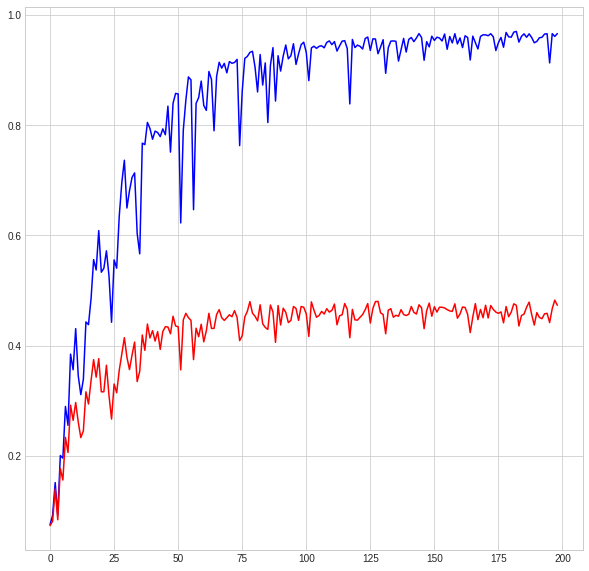

In [17]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_accs, 'b')
plt.plot(val_accs, 'r')
plt.savefig('accuracy.png', dpi = 300)

## Cross Entropy Loss

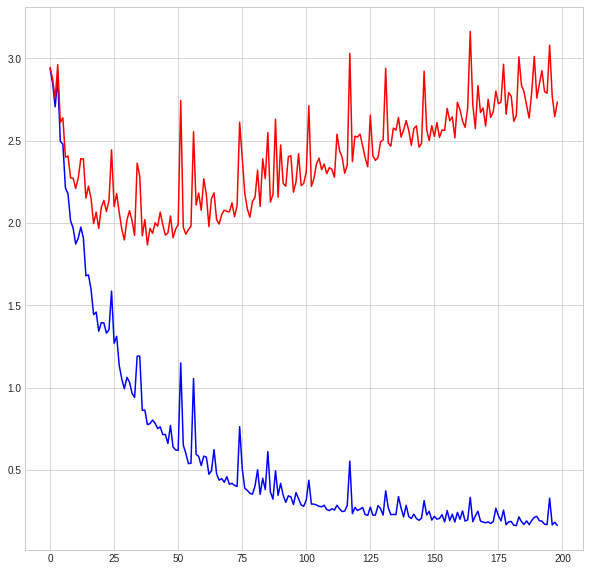

In [18]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_cross_entropys, 'b')
plt.plot(val_cross_entropys, 'r')
plt.savefig('cross entropy.png', dpi = 300)

## ECE

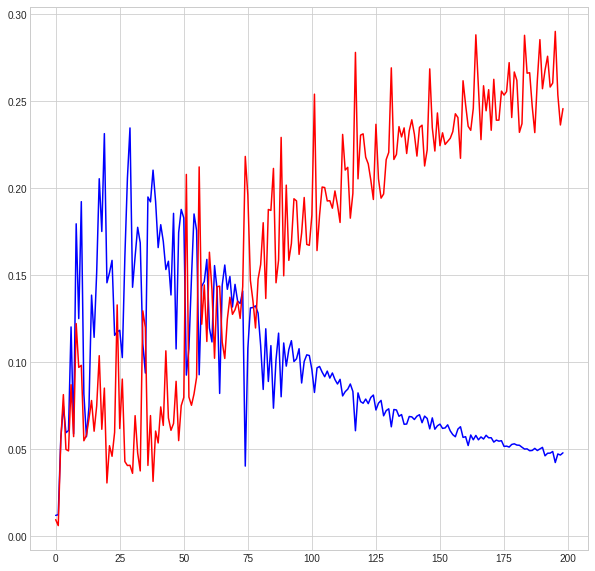

In [19]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_eces, 'b')
plt.plot(val_eces, 'r')
plt.savefig('ece.png', dpi = 300)

## MCE

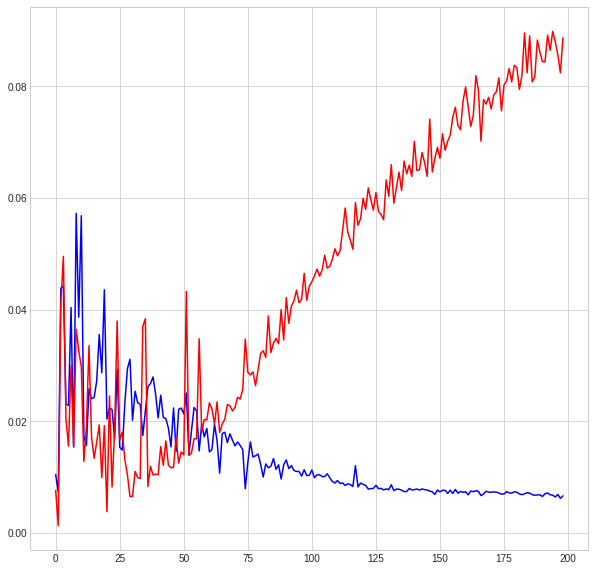

In [20]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_max_eces, 'b')
plt.plot(val_max_eces, 'r')
plt.savefig('mce.png', dpi = 300)